In [ ]:
!pip install -Uqq fastbook
from fastai.vision.all import *

     |████████████████████████████████| 720 kB 4.5 MB/s 
     |████████████████████████████████| 189 kB 31.9 MB/s 
     |████████████████████████████████| 1.2 MB 33.3 MB/s 
     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 51 kB 330 kB/s 


In [ ]:
# Check TensorFlow version
import tensorflow as tf
print(tf.__version__) # should be 2.5.0+

# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Get data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from timeit import default_timer as timer 

2.7.0


In [ ]:
def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    if device:  
        print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    else:
        print(f"\nTrain time: {total_time:.3f} seconds")
    return round(total_time, 3)

In [ ]:
# Setup hyperparameters
BATCH_SIZE = 32 # good for your health: https://twitter.com/ylecun/status/989610208497360896
EPOCHS = 5 # only run for a short period of time... we don't have all day
DATASET_NAME = "food101" 
DEVICE = "GPU"

In [ ]:
%%time
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name=DATASET_NAME, # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteDWVBAV/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteDWVBAV/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
CPU times: user 3min 18s, sys: 1min 12s, total: 4min 30s
Wall time: 14min 47s


## Check data

In [ ]:
# Check number of samples
len(train_data), len(test_data)

(75750, 25250)

In [ ]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10], len(class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 41
  Class name (str form): french_onion_soup
        


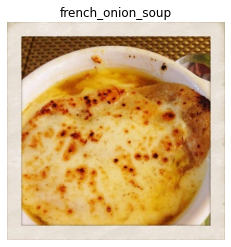

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)
  plt.imshow(image)
  plt.title(class_names[label.numpy()])
  plt.axis(False)

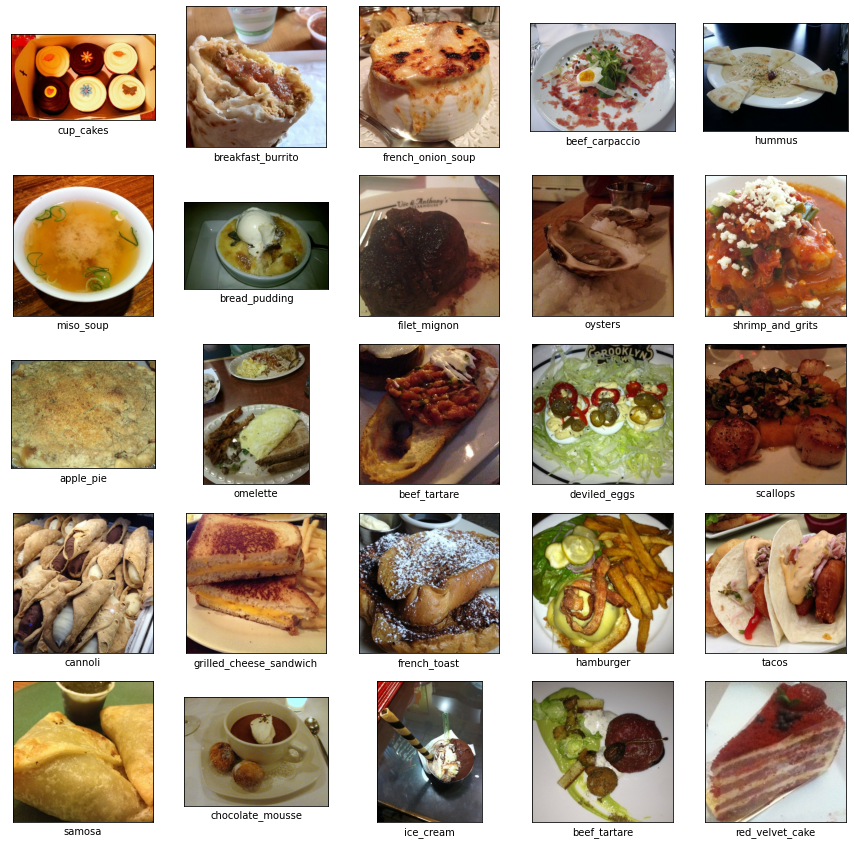

In [ ]:
plt.figure(figsize=(15,15))
for i, image in enumerate(train_data.take(25)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[0])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[image[1].numpy()])
plt.show()

## Preparar los datos

The data looks good. But before we model it, we're going to prepare it to run as fast as possible using [TensorFlow data loading best practices](https://www.tensorflow.org/guide/data_performance).

As EfficientNetB0 takes images of size (224, 224, 3), we'll resize all the images to that size.

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Ejemplo modelo pre-entrenado [No correr]

Estudiaremos como usar este tipo de modelos más en detale en el futuro

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB8(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x) # want one output neuron per class 
model = tf.keras.Model(inputs, outputs, name="EfficientNetB0_feature_extract")

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# Start timer
start_time = timer()

# Fit the model
history = model.fit(train_data, 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

# End timer
end_time = timer()

# Print results
train_time = print_train_time(start=start_time,
                              end=end_time,
                              device=DEVICE)

Epoch 1/5
2368/2368 [==============================] - 412s 163ms/step - loss: 1.8213 - accuracy: 0.5574 - val_loss: 1.2292 - val_accuracy: 0.6794
Epoch 2/5
2368/2368 [==============================] - 384s 161ms/step - loss: 1.2939 - accuracy: 0.6666 - val_loss: 1.1432 - val_accuracy: 0.6936
Epoch 3/5
2368/2368 [==============================] - 384s 161ms/step - loss: 1.1434 - accuracy: 0.7018 - val_loss: 1.0833 - val_accuracy: 0.7086
Epoch 4/5
2368/2368 [==============================] - 384s 161ms/step - loss: 1.0451 - accuracy: 0.7265 - val_loss: 1.0704 - val_accuracy: 0.7108
Epoch 5/5
2368/2368 [==============================] - 384s 161ms/step - loss: 0.9730 - accuracy: 0.7448 - val_loss: 1.0645 - val_accuracy: 0.7109

Train time on GPU: 2158.958 seconds


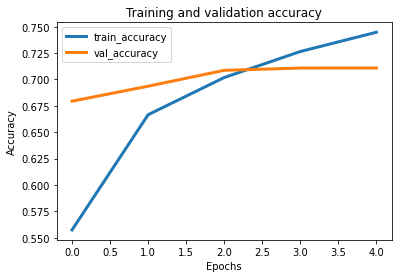

In [ ]:
plt.plot(history.history['accuracy'], lw = 3)
plt.plot(history.history['val_accuracy'], lw = 3)
plt.legend(["train_accuracy", 'val_accuracy'])
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy");

In [ ]:
# Predicciones en data que subimos nosotros
from ipywidgets import FileUpload
from IPython.display import display
uploader = FileUpload(multiple=True)
uploader

FileUpload(value={}, description='Upload', multiple=True)

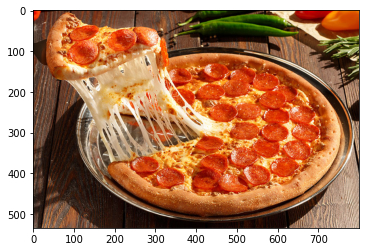

In [ ]:
img = uploader.data[0]
img = PILImage.create(img)
plt.imshow(img)

In [ ]:
from PIL import Image

def transform_img(img):
  # imgGray = img.convert('L')
  imgGray = img.resize((224,224))
  plt.imshow(imgGray)
  imgGray = np.array(imgGray) / 255.0
  imgGray = (np.expand_dims(imgGray,0))
  return imgGray

'croque_madame'

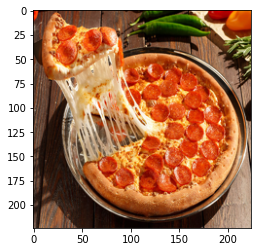

In [ ]:
pred = model.predict(transform_img(img))
class_names[np.argmax(pred)]

In [ ]:
np.argmax(pred)

28

In [ ]:
np.max(pred)

0.027119989

In [ ]:
pred

array([[0.01005875, 0.00671984, 0.01111303, 0.01216161, 0.00439567,
        0.00979486, 0.00592741, 0.01096125, 0.01358235, 0.01371322,
        0.00998896, 0.01116522, 0.00885403, 0.01266887, 0.00955164,
        0.00449989, 0.00666768, 0.0064384 , 0.00601964, 0.01029449,
        0.00828543, 0.00615645, 0.00761976, 0.00423854, 0.02024462,
        0.01351528, 0.00821629, 0.01276136, 0.02711999, 0.00513554,
        0.01467383, 0.00694433, 0.01102875, 0.0163575 , 0.00624472,
        0.01255688, 0.0066605 , 0.0065122 , 0.01052783, 0.01180846,
        0.00985558, 0.0107865 , 0.01156638, 0.00849864, 0.00997591,
        0.00384555, 0.01235193, 0.01154922, 0.01036794, 0.01273771,
        0.00757784, 0.00770899, 0.00566291, 0.01154342, 0.01308728,
        0.01045672, 0.01174114, 0.00657171, 0.01244615, 0.01894518,
        0.01260003, 0.00808779, 0.0132178 , 0.00812436, 0.01299454,
        0.00847771, 0.01129293, 0.00782668, 0.01017495, 0.00870009,
        0.01060174, 0.01643428, 0.00637133, 0.00

# Evaluación Grupal

In [ ]:
%%time
# Load in the data (takes about 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name=DATASET_NAME, # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds

                                             # Make a function for preprocessing images
def preprocess_img(image, label, img_shape=32):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1024).batch(batch_size=1024).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Cause: Unable to locate the source code of <function preprocess_img at 0x7f9c74fbc290>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function preprocess_img at 0x7f9c74fbc290>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function preprocess_img at 0x7f9c74fbc290>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 136 ms, sys: 7.3 ms, total: 143 ms
Wall time: 142 ms


In [ ]:
model = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', # adam, sgd
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, 
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data), 
                    callbacks=[callback])

Epoch 1/5
74/74 [==============================] - 151s 2s/step - loss: 64.8249 - accuracy: 0.0097 - val_loss: 4.6152 - val_accuracy: 0.0099
Epoch 2/5
74/74 [==============================] - 129s 2s/step - loss: 4.6154 - accuracy: 0.0090 - val_loss: 4.6151 - val_accuracy: 0.0099
Epoch 3/5
74/74 [==============================] - 132s 2s/step - loss: 4.6153 - accuracy: 0.0087 - val_loss: 4.6151 - val_accuracy: 0.0099
Epoch 4/5
74/74 [==============================] - 132s 2s/step - loss: 4.6153 - accuracy: 0.0094 - val_loss: 4.6151 - val_accuracy: 0.0099
Epoch 5/5
74/74 [==============================] - 132s 2s/step - loss: 4.6153 - accuracy: 0.0084 - val_loss: 4.6151 - val_accuracy: 0.0099


In [ ]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2,2)),
    model.add(keras.layers.BatchNormalization()),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    model.add(keras.layers.BatchNormalization()),
    layers.Flatten()
    layers.Dense(128, activation='relu', use_bias = False),
    layers.Dense(len(class_names), activation='softmax')
])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile(optimizer='adam', # adam, sgd
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_data, 
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data), 
                    callbacks=[callback])